# Concept Activation Vectors (CAVs) example on CIFAR data
### Peter Xenopoulos

In this workbook, we will go over how to use CAVs on some popular image data -- the CIFAR datasets.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.cav import *

np.random.seed(1996)

Using TensorFlow backend.


First we must import some images from CIFAR-10. We will import the _airplanes_ and the _bird_ images.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep ships (8) from CIFAR-10
interested_class = y_train == [8]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

Below is an example of some of the images

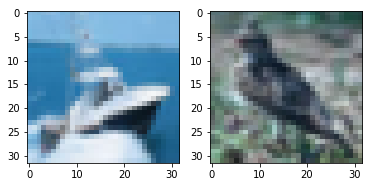

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

Next, we must specify a _concept_. This is a certain idea we want to capture from our pictures. Let's say we are interested in the concept of the _sea_. Let's load in CIFAR-100 to get some pictures of the sea and some random counterexamples.

In [4]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (71) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = [1] * 500
y_train_concept = y_train_concept + [0] * 500

counterexamples = create_counterexamples(n = 500, height = 32, width = 32, channels = 3)
x_train_concept = np.append(x_train_concept, counterexamples, axis = 0)

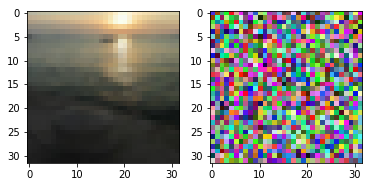

In [5]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_concept[0].astype(np.uint8))
axarr[1].imshow(x_train_concept[777].astype(np.uint8))

Now, we must train our initial model. We do so below.

In [6]:
# Set parameters
batch_size = 32
epochs = 3

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
10000/10000 [==============================] - 33s 3ms/step - loss: 0.3521 - acc: 0.8450
Epoch 2/3
10000/10000 [==============================] - 31s 3ms/step - loss: 0.2313 - acc: 0.9078
Epoch 3/3
10000/10000 [==============================] - 30s 3ms/step - loss: 0.1920 - acc: 0.9251


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

First, we split our model on a given layer. We can see that the last convolution layer is layer 8, but in order for our method to work, we need to include the activations and pooling and flattening. So, we will split on layer 12. Then, we train a binary classifier on our concepts. This will produce our concept activation vector.

In [8]:
model_f, model_h = return_split_models(model, 12)
cav_vec = train_cav(model_f, x_train_concept, y_train_concept)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Below we see the concept activation vector

In [9]:
cav_vec

array([[ -0.        ],
       [-30.46255422],
       [ -0.        ],
       ...,
       [ -0.        ],
       [ -0.        ],
       [ 17.23929691]])

Now, for each original training example, we calculate the sensitivity to the concept using our `cav_vec`

In [10]:
sensitivities_ship = conceptual_sensitivity(x_train, y_train, model_f, model_h, cav_vec)

Then, we plot the distributions of the sensitivities. We know that the first 5000 belong to the first class (ships) and the last 5000 belong to the second class (birds).

(-0.015, 0.015)

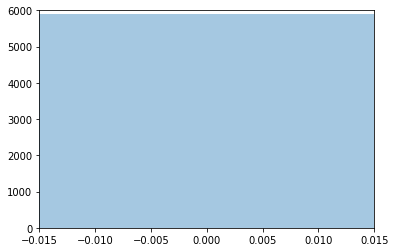

In [11]:
sns.distplot(sensitivities_ship, kde = False)

plt.ylim(0, 6000)
plt.xlim(-0.015, 0.015)

(-0.015, 0.015)

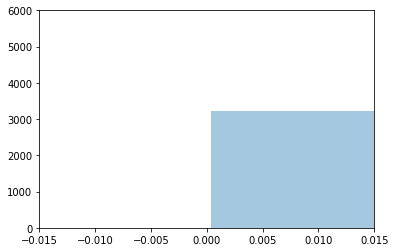

In [12]:
sns.distplot(sensitivities_ship[0:4999], kde = False)

plt.ylim(0, 6000)
plt.xlim(-0.015, 0.015)

(-0.015, 0.015)

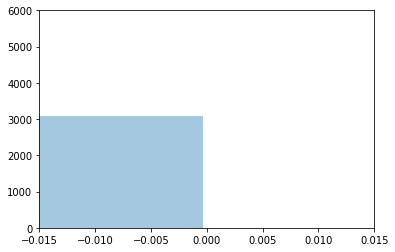

In [13]:
sns.distplot(sensitivities_ship[5000:], kde = False)

plt.ylim(0, 6000)
plt.xlim(-0.015, 0.015)

Now, we check to see the sensitivity for each class by checking how many of the sensitivities are greater than 0 for both the ships and the birds.

In [14]:
ship_sens = np.sum(sensitivities_ship[0:4999] > 0)/5000
bird_sens = np.sum(sensitivities_ship[5000:] > 0)/5000

print("SHIPS have a sensitivity of " + str(ship_sens) + " to the SEA concept")
print("BIRDS have a sensitivity of " + str(bird_sens) + " to the SEA concept")

SHIPS have a sensitivity of 0.9998 to the SEA concept
BIRDS have a sensitivity of 0.0 to the SEA concept


### Airplane Example

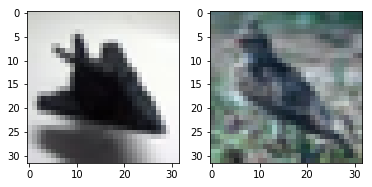

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes from CIFAR-10
interested_class = y_train == [0]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

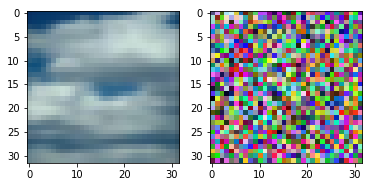

In [16]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep cloud (23) from CIFAR-100
concept = y_train_concept == [23]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = [1] * 500
y_train_concept = y_train_concept + [0] * 500

counterexamples = create_counterexamples(n = 500, height = 32, width = 32, channels = 3)
x_train_concept = np.append(x_train_concept, counterexamples, axis = 0)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_concept[6].astype(np.uint8))
axarr[1].imshow(x_train_concept[777].astype(np.uint8))

In [17]:
# Set parameters
batch_size = 32
epochs = 3

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
10000/10000 [==============================] - 28s 3ms/step - loss: 0.4632 - acc: 0.7924
Epoch 2/3
10000/10000 [==============================] - 27s 3ms/step - loss: 0.3513 - acc: 0.8506
Epoch 3/3
10000/10000 [==============================] - 28s 3ms/step - loss: 0.3212 - acc: 0.8659


In [18]:
model_f, model_h = return_split_models(model, 12)
cav_vec = train_cav(model_f, x_train_concept, y_train_concept)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [19]:
sensitivities_airplane = conceptual_sensitivity(x_train, y_train, model_f, model_h, cav_vec)

We won't plot the distributions here, but we will show the sensitivities below.

In [20]:
airplane_sens = np.sum(sensitivities_airplane[0:4999] > 0)/5000
bird_sens = np.sum(sensitivities_airplane[5000:] > 0)/5000

print("AIRPLANES have a sensitivity of " + str(airplane_sens) + " to the SKY concept")
print("BIRDS have a sensitivity of " + str(bird_sens) + " to the SKY concept")

AIRPLANES have a sensitivity of 0.9302 to the SKY concept
BIRDS have a sensitivity of 0.775 to the SKY concept
